# Define Study Areas & Control Province
Finalize and acquire boundary polygons for all six primary provinces.

In [1]:
# 1) Imports & I/O engine check
from pathlib import Path
import warnings
import sys
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# shapely >= 2 has make_valid; fall back to buffer(0) if not
try:
    from shapely import make_valid
    HAS_MAKE_VALID = True
except Exception:
    HAS_MAKE_VALID = False

# Prefer pyogrio for fast, clean I/O; fall back to fiona if not available
def _choose_engine():
    try:
        import pyogrio  # noqa: F401
        return "pyogrio"
    except Exception:
        try:
            import fiona  # noqa: F401
            return "fiona"
        except Exception:
            raise ImportError(
                "Neither 'pyogrio' nor 'fiona' is available. Install one:\n"
                "  conda install -c conda-forge pyogrio\n"
                "or\n"
                "  conda install -c conda-forge fiona"
            )

IO_ENGINE = _choose_engine()
print("Vector I/O engine:", IO_ENGINE)


Vector I/O engine: pyogrio


In [2]:
# 2) Configuration (project paths, CRS, schema)
DATA_RAW = Path("../../../data/raw/boundaries")
DATA_OUT = Path("../../../data/processed")
SHAPEFILE_PATH = DATA_RAW / "study_provinces.shp"   # EDIT ME if your source differs
OUTPUT_GPKG_PATH = DATA_OUT / "study_area_provinces.gpkg"

# Equal-area CRS for CONUS analytics
PROJECT_CRS = "EPSG:5070"

# Province name handling — your file shows PROVINCE/PROVCODE
# We'll normalize to uppercase to be robust to case.
PROVINCE_NAME_CANDIDATES = ["PROVINCE", "PROV_NAME", "NAME", "REGION"]

# Control province (exact string after normalization to uppercase) — EDIT ME
CONTROL_PROVINCE = "PIEDMONT"  # e.g., "PIEDMONT", "COASTAL PLAIN", etc.

# Optional: lock to expected set (for warnings)
EXPECTED_PROVINCES = [
    # EDIT ME (optional): list the six canonical names in UPPERCASE if you want strict QA
    # "COASTAL PLAIN", "PIEDMONT", "APPALACHIAN PLATEAUS",
    # "BASIN AND RANGE", "VALLEY AND RIDGE", "BLUE RIDGE"
]

# Output layer names inside the GeoPackage
LAYER_PROVINCES = "provinces"
LAYER_CONTROL = "control_province"


In [3]:
# 3) Load, inspect, standardize columns, and fix active geometry
print(f"Loading: {SHAPEFILE_PATH}")
gdf = gpd.read_file(SHAPEFILE_PATH, engine=IO_ENGINE)

print("Original CRS:", gdf.crs)
print("Original columns:", list(gdf.columns))

# Keep a raw copy for safety
gdf_raw = gdf.copy()

# --- Robust column normalization that preserves/repairs the geometry column ---
orig_geom_name = gdf.geometry.name  # usually "geometry"
# Build a mapping to uppercase for non-geometry columns only
rename_map = {c: c.upper() for c in gdf.columns if c != orig_geom_name}
gdf = gdf.rename(columns=rename_map)

# If the read engine created a non-standard geometry col name, normalize it
# Detect any geometry-typed columns
geom_cols = [c for c in gdf.columns if gdf[c].dtype.name == "geometry"]
if len(geom_cols) == 0:
    raise AttributeError("No geometry-typed column found after renaming.")

# Prefer the original active geometry if still present; otherwise pick the first geometry col
active_geom = orig_geom_name if orig_geom_name in gdf.columns else geom_cols[0]

# Ensure the active geometry is properly set (this also updates gdf.geometry.name)
if gdf.geometry.name != active_geom:
    gdf = gdf.set_geometry(active_geom)

# For consistency, rename the active geometry column to "geometry"
if gdf.geometry.name != "geometry":
    gdf = gdf.rename_geometry("geometry")

print("Standardized columns:", list(gdf.columns))
print("Active geometry column:", gdf.geometry.name)
display(gdf.head())


Loading: ..\..\data\raw\boundaries\study_provinces.shp
Original CRS: EPSG:6318
Original columns: ['PROVINCE', 'PROVCODE', 'Shape_Leng', 'Shape_Area', 'geometry']
Standardized columns: ['PROVINCE', 'PROVCODE', 'SHAPE_LENG', 'SHAPE_AREA', 'geometry']
Active geometry column: geometry


,PROVINCE,PROVCODE,SHAPE_LENG,SHAPE_AREA,geometry
0,COASTAL PLAIN,3,306.942823,107.777346,"MULTIPOLYGON (((-91.06888 29.31639, -91.0746 2..."
1,PIEDMONT,4,34.302366,20.211476,"POLYGON ((-76.23408 40.3703, -76.15117 40.3902..."
2,APPALACHIAN PLATEAUS,8,43.626928,30.887238,"POLYGON ((-84.23506 37.56641, -84.21626 37.569..."
3,BASIN AND RANGE,22,71.632279,90.923162,"POLYGON ((-103.15391 28.97889, -103.22546 28.9..."
4,VALLEY AND RIDGE,6,42.346232,12.531886,"POLYGON ((-81.42378 37.28854, -81.35377 37.335..."


In [4]:
# 4) Province name column selection & geometry validity fixes
province_col = None
for c in PROVINCE_NAME_CANDIDATES:
    if c in gdf.columns:
        province_col = c
        break

if province_col is None:
    raise ValueError(
        f"Could not find a province-name column. Tried {PROVINCE_NAME_CANDIDATES}. "
        f"Available columns: {list(gdf.columns)}"
    )

# Normalize strings: strip & uppercase (columns are already uppercase)
gdf[province_col] = gdf[province_col].astype(str).str.strip().str.upper()

# Geometry validity repair
if not gdf.geometry.is_valid.all():
    warnings.warn("Invalid geometries detected; attempting to repair.")
    if HAS_MAKE_VALID:
        gdf["geometry"] = gdf.geometry.apply(make_valid)
    else:
        gdf["geometry"] = gdf.buffer(0)

# Drop empties just in case
gdf = gdf[~gdf.geometry.is_empty].copy()
assert len(gdf) > 0, "No valid features remain after geometry repair."


In [5]:
# 5) Reproject, dissolve-by-name (if multipart), and QA
print(f"Reprojecting to {PROJECT_CRS} ...")
gdf_proj = gdf.to_crs(PROJECT_CRS).copy()

# If multiple rows per province exist, dissolve to one feature per province
gdf_proj = (
    gdf_proj
    .dissolve(by=province_col, as_index=False, aggfunc="first")
    .reset_index(drop=True)
)

# Basic QA
unique_names = sorted(gdf_proj[province_col].unique().tolist())
print("Detected provinces:", unique_names)
if EXPECTED_PROVINCES:
    missing = set(EXPECTED_PROVINCES) - set(unique_names)
    extra = set(unique_names) - set(EXPECTED_PROVINCES)
    if missing:
        warnings.warn(f"Missing expected provinces: {sorted(missing)}")
    if extra:
        warnings.warn(f"Found unexpected provinces: {sorted(extra)}")

if len(unique_names) != 6:
    warnings.warn(f"Expected 6 provinces; found {len(unique_names)}.")

# Tag the control province
if CONTROL_PROVINCE:
    if CONTROL_PROVINCE not in unique_names:
        warnings.warn(f"CONTROL_PROVINCE='{CONTROL_PROVINCE}' not found in data.")
    gdf_proj["IS_CONTROL"] = gdf_proj[province_col].eq(CONTROL_PROVINCE)
else:
    gdf_proj["IS_CONTROL"] = False


Reprojecting to EPSG:5070 ...
Detected provinces: ['APPALACHIAN PLATEAUS', 'BASIN AND RANGE', 'BLUE RIDGE', 'COASTAL PLAIN', 'PIEDMONT', 'VALLEY AND RIDGE']


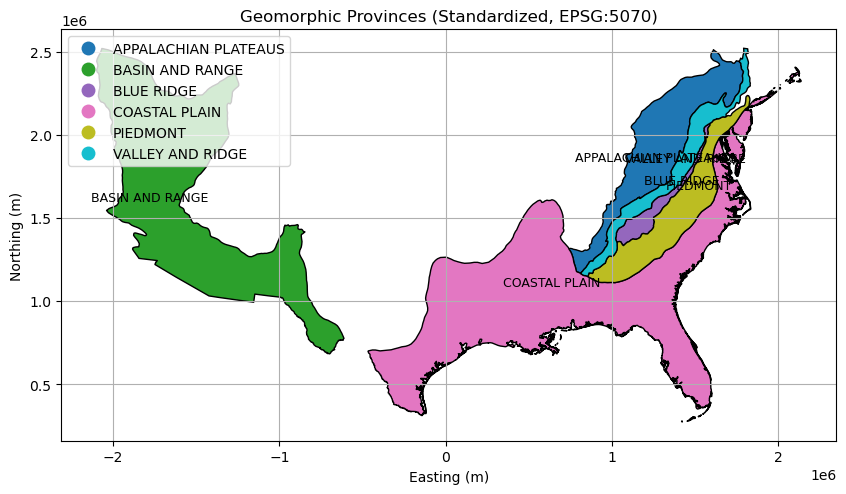

Control province set? YES (count marked = 1)


In [6]:
# 6) Visual check
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, edgecolor="black", column=province_col, legend=True)

ax.set_title("Geomorphic Provinces (Standardized, EPSG:5070)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.grid(True)

# Label representative points (safer than centroids for thin geometries)
reps = gdf_proj.geometry.representative_point()
for name, (x, y) in zip(gdf_proj[province_col], zip(reps.x, reps.y)):
    ax.text(x, y, name, fontsize=9, ha="center")

plt.show()

n_control = int(gdf_proj["IS_CONTROL"].sum())
print(f"Control province set? {'YES' if n_control==1 else 'NO'} (count marked = {n_control})")


In [7]:
# 7) Save standardized outputs
DATA_OUT.mkdir(parents=True, exist_ok=True)
print(f"Writing layers to: {OUTPUT_GPKG_PATH}")

# Full provinces layer
gdf_proj.to_file(OUTPUT_GPKG_PATH, layer=LAYER_PROVINCES, driver="GPKG")

# Convenience: control-only layer
if gdf_proj["IS_CONTROL"].any():
    gdf_ctrl = gdf_proj[gdf_proj["IS_CONTROL"]].copy()
    gdf_ctrl.to_file(OUTPUT_GPKG_PATH, layer=LAYER_CONTROL, driver="GPKG")

print("Done.")


Writing layers to: ..\..\data\processed\study_area_provinces.gpkg
Done.
